# **Visualization of the NTU RGB+D Action Recognition Dataset**

___
___

## **1. Initialization**

### *1.1. Imports*

In [1]:
from PIL import Image, ImageDraw
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os

from torch.utils.data import Dataset

import torch

In [2]:
# to fill the requirement.txt file we use the following line of code:
import session_info
session_info.show()

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. Data Loading*

In [4]:
data2D_dir = "data/nturgbd60_skeletons_2D/"
data3D_dir = "data/nturgbd60_skeletons_3D/"

data2D_files = os.listdir(data2D_dir)
data3D_files = os.listdir(data3D_dir)

In [5]:
with open("data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [6]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [7]:
class HumanActionDataset2D(Dataset):

    def __init__(self, data_dir, data_files, classes, with_depth=True, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.with_depth = with_depth
        self.flatten =  flatten

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if not self.with_depth:
            tensor = tensor[:,:,:2]
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [8]:
class HumanActionDataset3D(Dataset):

    def __init__(self, data_dir, data_files, classes, flatten=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.flatten =  flatten

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.flatten:
            tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [9]:
HAD2D = HumanActionDataset2D(data2D_dir, data2D_files, classes, with_depth=False, flatten=False)
HAD3D = HumanActionDataset3D(data3D_dir, data3D_files, classes, flatten=False)

___

## **2. Create Images**

In [10]:
# sequences of joints to display the members of the squeletons

bust_joints = [0, 1, 20, 2, 3]

right_arm_joint = [23, 24, 11, 10, 9, 8]
left_arm_joint = [21, 22, 7, 6, 5, 4]
arm_joints = [23, 24, 11, 10, 9, 8, 20, 4, 5, 6, 7, 22, 21]

right_leg_joints = []
left_leg_joints = []
leg_joints = [19, 18, 17, 16, 0, 12, 13, 14, 15]

body_joints = [bust_joints, arm_joints, leg_joints]

In [11]:
def get_image_sequence(i, dataset2D=HAD2D, dataset3D=HAD3D):
    
    """
    inputs:
    * (int) i : index of the sample to consider
    * dataset2D : dataset with the pixel information
    * dataset3D : dataset with the space information (if not None we will consider the depth in the generated images)

    output:
    * final_image_sequence : sequence (frame by frame) of images + depth
    """
    
    xy_sequence = dataset2D[i][0]
    image_sequence = np.zeros((xy_sequence.shape[0],25,3))
    
    if dataset3D != None:
        z_sequence = dataset3D[i][0][:,:,2]
    else:
        z_sequence = np.zeros((xy_sequence.shape[0],25))
    
    for m in range(xy_sequence.shape[0]):
        for n in range(25):
            x = min(int(xy_sequence[m,n,0].item()),1920)-1
            y = min(int(xy_sequence[m,n,1].item()),1080)-1
            z = z_sequence[m,n].item()
            image_sequence[m,n] = [x,y,z]
    
    return  image_sequence

In [12]:
def get_image_sequence_normalize(i, dataset2D=HAD2D, dataset3D=HAD3D):
    # get pixels but also normalize the depth between 0 and 1
    image_sequence = get_image_sequence(i, dataset2D, dataset3D)
    mini = image_sequence[:,:,2].min()
    maxi = image_sequence[:,:,2].max()
    if mini != maxi:
        image_sequence[:,:,2] = (image_sequence[:,:,2]-mini)/(maxi-mini)
    return image_sequence

In [13]:
def create_image(image_frame):

    img = Image.new("RGB", (1920,1080 ), color="black")
    
    for body_part in body_joints:
        
        for i in range(len(body_part)-1):
            
            a = image_frame[body_part[i]]
            b = image_frame[body_part[i+1]]-a
            n = 10
            line = np.array([a+(i/n)*b for i in range(n)])

            for i in range(len(line)-1):
                x1,y1,z = line[i]
                x2,y2,_ = line[i+1]
                draw = ImageDraw.Draw(img)
                color = tuple((int(255*z),0,int(255*(1-z))))
                draw.line((x1,y1,x2,y2), fill=color,width=5)
    return img

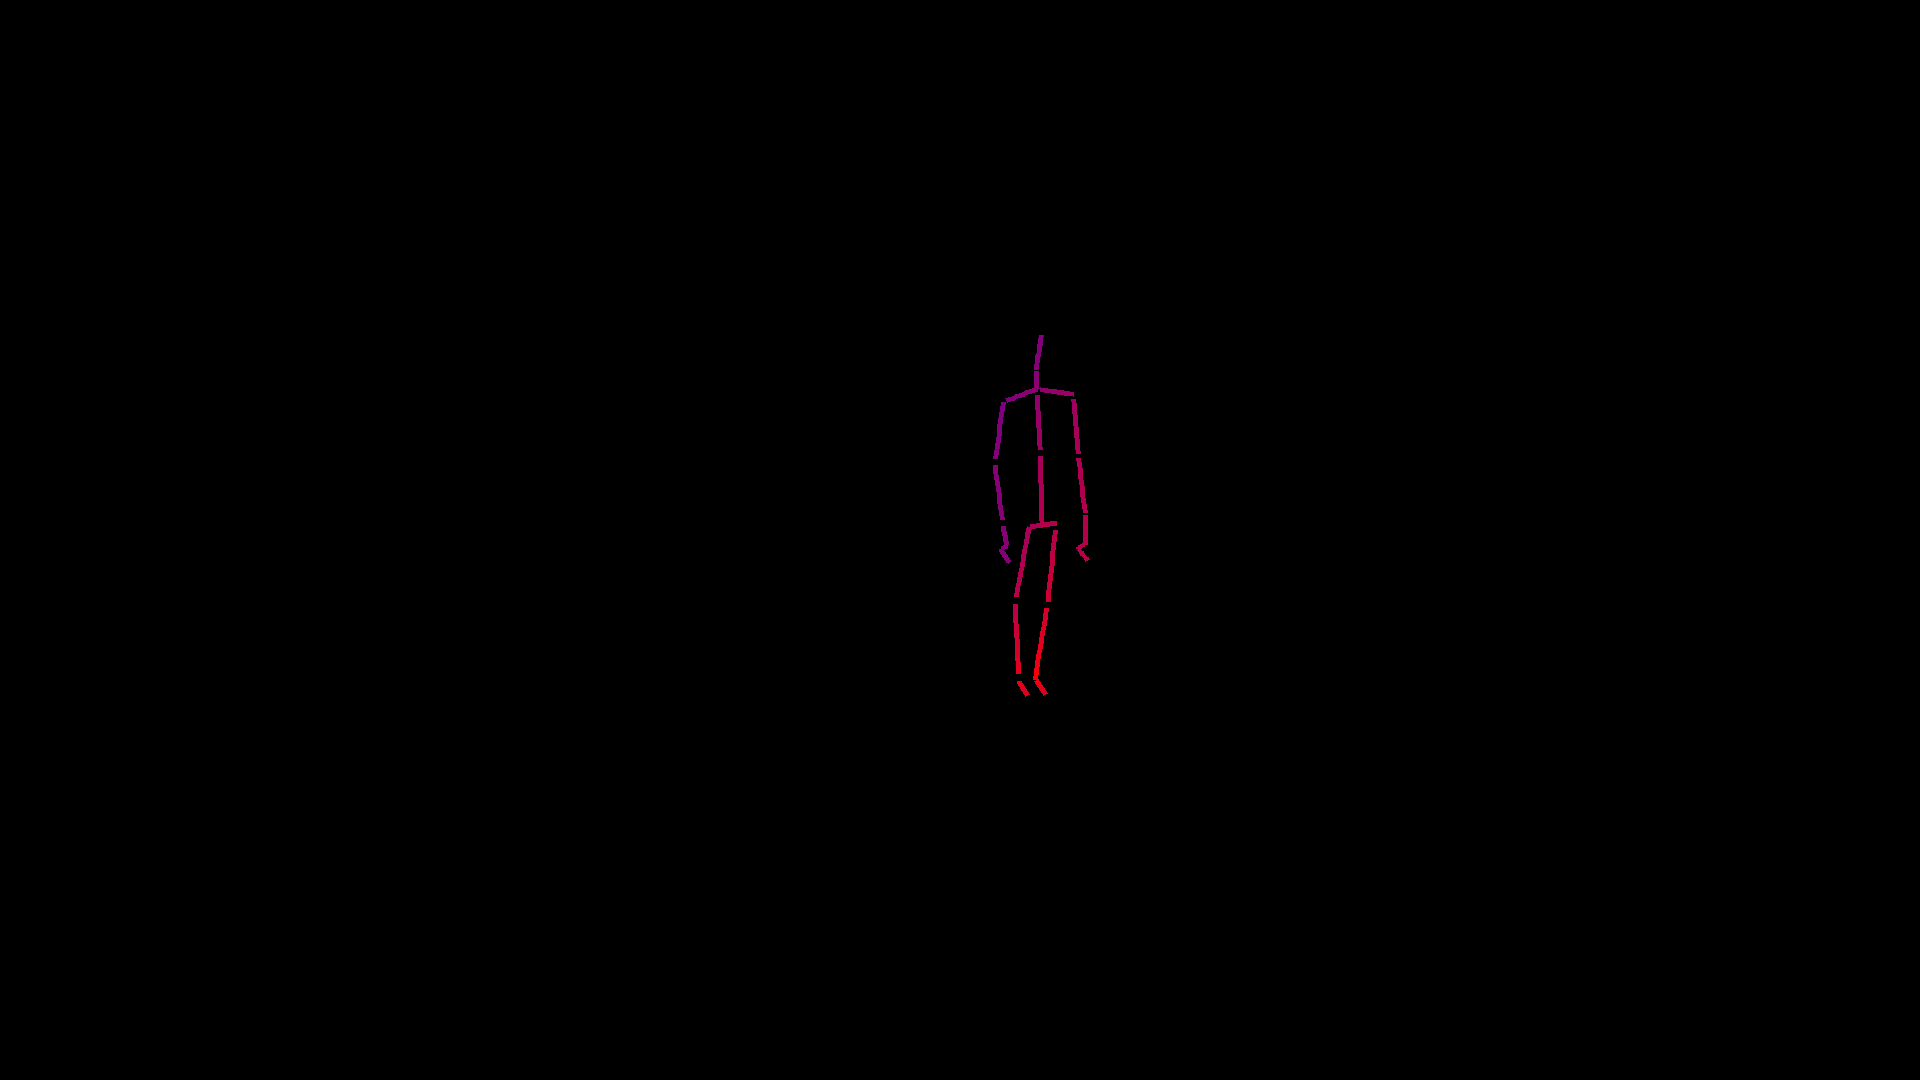

In [14]:
# example (first element of the dataset)
create_image(get_image_sequence_normalize(15)[0,:,:])

In [15]:
def create_gif(i, filepath, dataset2D=HAD2D, dataset3D=HAD3D, normalize=True):
    if normalize:
        image_sequence = get_image_sequence_normalize(i, dataset2D, dataset3D)
    else:
        image_sequence = get_image_sequence(i, dataset2D, dataset3D)
    seq = [create_image(frame) for frame in image_sequence]
    seq[0].save(filepath, save_all=True, append_images=seq[1:])

In [16]:
if "gifs" not in os.listdir("./data/"):
    os.mkdir("./data/gifs")

In [17]:
for index in range(100):
    create_gif(index, "./data/gifs/sample_{}_A{}.gif".format(index, classes[HAD2D[index][1]]))

___
___